In [1]:
import numpy as np
import Derivatives as Div
import Cheb as Ch
import Solver as Sol
import Plotting 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

np.set_printoptions(linewidth=200)

class Parent:
    x = None

class Child1(Parent):
    def __init__(self) -> None:
        self.x = [1, 2]

parent = Parent()
child = Child1()

print(parent.x)
print(child.x)
print(Parent.x)
print(Child1.x)

None
[1, 2]
None
None


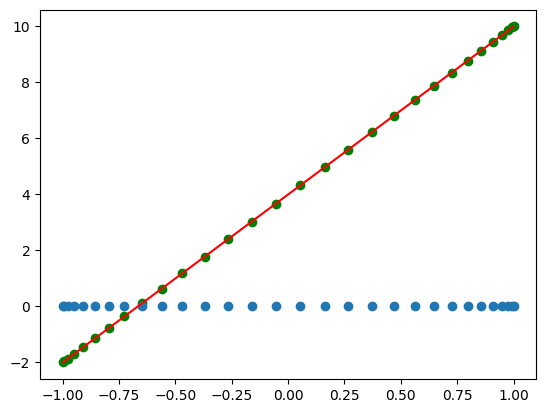

In [2]:
def poly3(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d

def poly3div(x, a, b, c):
    return 3*a*x*x + 2*b*x + c

def poly3bis(x, a, b, c):
    return 6*a*x + 2*b

N = 30          
x = Ch.Grid(N, mode='cheb').grid
D = Div.DR(N).matrix
D2 = Div.DR2(N).matrix

a, b, c, d = 1, 2, 3, 4

ydata = [poly3(i, a, b, c, d) for i in x]   # 3rd degree polynomial values
yRef = [poly3bis(i, a, b, c) for i in x] # true derivative
yRef2 = [poly3div(i, a, b, c) for i in x] # true 2nd derivative
yD = D @ ydata                                # spectral derivative
yD2 = D2 @ ydata                              # 2nd spectral derivative


# plt.scatter(x, yD, c='black')
plt.plot(x, yRef, 'r')
plt.scatter(x, yRef, c='green')
plt.scatter(x, [0 for i in range(N)])
plt.show()


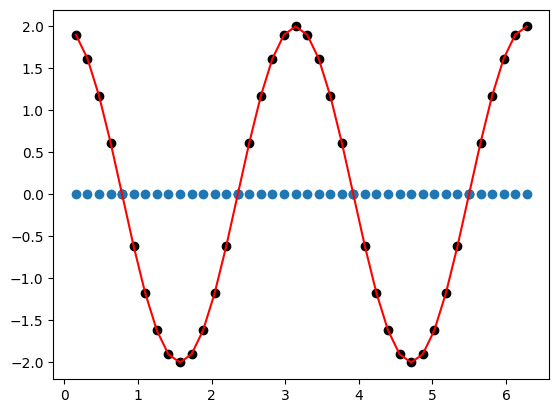

In [3]:
def sin(x, a, b, c, d):
    return a * np.sin(b*x + c)

def sinDiv(x, a, b, c, d):
    return a*b * np.cos(b*x + c)

N = 40
x = Ch.Grid(N, mode='uni').grid
D = Div.DTheta(N).matrix

a, b, c, d = 1, 2, 0, 4

ydata = [sin(i, a, b, c, d) for i in x]   # 3rd degree polynomial values
yRef = [sinDiv(i, a, b, c, d) for i in x] # true derivative
yD = D.dot(ydata)                            # spectral derivative

#print(yD - yRef)

plt.plot(x, yRef, 'r')
plt.scatter(x, yD, c='black')
plt.scatter(x, [0 for i in range(N)])
plt.show()

In [36]:
# use trick with mirroring radial grid - requires modification to differentiation matrix
# N = 6
NR, NTheta = 40, 30
dimR = NR-2
r = Ch.Grid(NR, mode="cheb").grid[NR//2:-1]
# r = Ch.Grid(NR, mode="cheb").grid[1:NR//2]
r = np.flip(r)
print(r)
t = Ch.Grid(NTheta, mode="uni").grid
D = Div.DR2(NR).matrix[1:-1, 1:-1]
E = Div.DR(NR).matrix[1:-1, 1:-1]
T = Div.DTheta2(NTheta).matrix
R = np.diag(1/r)

d1, d2 = D[:dimR//2, :dimR//2], D[:dimR//2, -1:dimR//2:-1]
e1, e2 = E[:dimR//2, :dimR//2], E[:dimR//2, -1:dimR//2:-1]

diagId = np.identity(NTheta)
antiDiagId = np.kron(np.array([[0, 1], [1, 0]]), np.identity(NTheta//2))

operator = np.kron(d1 + (R @ e1), diagId) + np.kron(d2 + (R @ e2), antiDiagId) + np.kron(R @ R, T)
# D = Div.DR2(NR)
# D.matrix = D.matrix[1:-1, 1:-1]
# DPrime = D.blockSymmetrize('L', NTheta)

# E = Div.DR(NR)
# E.matrix = E.matrix[1:-1, 1:-1] @ np.kron(np.ones((2,2)), R)
# EPrime = E.blockSymmetrize('L', NTheta)

# operator = DPrime + EPrime + np.kron(R @ R, T)

#shape check
print(operator.shape)
print(np.kron(r, t).shape)

source = np.kron(-1*r*r, np.sin(t/2)**4) + np.kron(np.ones(len(r)), np.sin(6*t) * np.cos(t/2)**2)
# source = np.kron(np.ones(len(r)), np.ones(NTheta))
sol = np.linalg.solve(operator, source)

# print("Operator Rank: ", np.linalg.matrix_rank(operator))


# Create the mesh in polar coordinates and compute corresponding Z.
plotter = Plotting.PolarPlotter()
plotter.plot(r, t, sol, colormap='viridis')  # r, t, sol are 1D vectors, plotter handles reshaping 


[0.99675731 0.98705026 0.97094182 0.94853644 0.91997944 0.88545603 0.84519009 0.79944276 0.74851075 0.69272435 0.63244538 0.56806475 0.5        0.42869256 0.35460489 0.27821746 0.20002569 0.12053668
 0.04026594]
(19, 19)


ValueError: operands could not be broadcast together with shapes (570,570) (570,540) 

Lattice size:  60
Size after boundary conditions:  3364


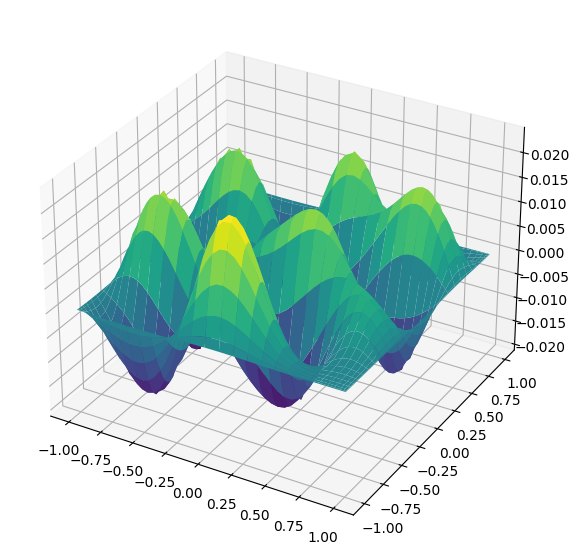

In [8]:
# 2D examples: Poisson and Helmholtz equations

# Data:
solver = Sol.SpectralSolverCart2D()
N = 60
dim = N-2
k = 9
x, y = Ch.Grid(N).grid[1:-1], Ch.Grid(N).grid[1:-1]
D = Div.DR2(N).matrix[1:-1, 1:-1]

# Helmholtz equation, source 
L = np.kron(np.identity(dim), D) + np.kron(D, np.identity(dim)) + k*k * np.identity(dim**2)
source = np.exp(np.kron(np.ones(dim), -10*(y-1)**2) + np.kron(-10*(x-0.5)**2, np.ones(dim)))

# Poisson equation, source and solution
# L = np.kron(np.identity(dim), D) + np.kron(D, np.identity(dim))
# source = 10*np.sin(np.kron(8*x, y-1))
sol = solver.solve(L, source)

print("Lattice size: ", N)
print("Size after boundary conditions: ", dim*dim)
# print("L rank: ", np.linalg.matrix_rank(L))


Plotting.CartesianPlotter2D().plot(x, y, sol)


In [19]:
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

print(np.kron(b,a))

[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]


In [21]:
r = np.array([-1, 1])
t = np.array([0, 3.14])

print(np.kron(r,t).reshape((2,2)))

[[-0.   -3.14]
 [ 0.    3.14]]
